# Overview
The task is to identify sleep patterns given samples of accelerometer data. 

In [1]:
# Render our plots inline
%matplotlib inline

import numpy as np
import h5py
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
from pandas import HDFStore,DataFrame
import itertools
import math

In [2]:
def load_data(filename):
    path = 'D:/path/'+ filename
    hf = h5py.File(path, 'r')

    reread = pd.read_hdf(path)
    data = reread#.head(10000)
    hf.close()
    return data


def load_csv(filename):
    data = pd.read_csv('D:/path/'+ filename)
    
    return data

def load_targets(subject_number):
    filename = 'D:/path/ID'+str(subject_number)+'/PSG'+ str(subject_number) +'_targets.h5'
    hf = h5py.File(filename, 'r')

    reread = pd.read_hdf(filename)
    targets = reread#.head(10000)
    hf.close()
    return targets

def load_features(subject_number):
    filename = 'D:/path/ID'+str(subject_number)+'/PSG'+ str(subject_number) +'_features.h5'
    hf = h5py.File(filename, 'r')

    reread = pd.read_hdf(filename)
    features = reread#.head(10000)
    hf.close()
    return features

In [3]:
def combine_data(subject_ids):
    
    data = []
    y = []
    
    
    for i in range(len(subject_ids)):
        
        features = load_features(subject_ids[i])
        targets = load_targets(subject_ids[i])
        
        data.append(features)
        y.append(targets)
    
    result_X = pd.concat(data)
    result_X = result_X.reset_index()
    result_X = result_X.drop(['index'], axis = 1)
    
    result_y = pd.concat(y)
    result_y = result_y.reset_index()
    result_y = result_y.drop(['index'], axis = 1)
    
    return result_X, result_y.values.ravel()

In [4]:
X_train = load_data('X_train_comv_xgb.h5')

y_train = load_data('y_train_comv_xgb.h5').values.ravel()


In [5]:
# subject_ids = [1,6,14,15,18,19,20,23,24,25,27,28,29,30,31,37,39]

train_ids =[1, 6, 15, 19, 20, 23, 24, 25, 27, 29, 28, 30, 31, 32, 35, 37, 39]

#val_ids = [32, 35]

test_ids = [14, 18]

#X_train, y_train = combine_data(train_ids)
X_test, y_test = combine_data(test_ids)
#X_test, y_test = combine_data(val_ids)


# Model building and evaluation

In [6]:
import sklearn.metrics as met
import seaborn as sn

# helper function to quickly build different models
def model_build(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def plot_confusion_matrix(array):
    array = array
    x_labels = ['sleep', 'wake']
    y_labels = ['sleep', 'wake']
    df_cm = pd.DataFrame(array, y_labels,x_labels)
    plt.figure(figsize = (4,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", fmt='g')# font size
    plt.show()

# helper function to handle evaluation
def model_eval(y_test, pred):
    print('Accuracy:\n-----------------------------')
    print(met.accuracy_score(y_test, pred))
    print('\nConfusion Matrix:\n-----------------------------')
    conf = met.confusion_matrix(y_test, pred)
    plot_confusion_matrix(conf)
    #print(met.confusion_matrix(y_test, pred))
    print('\nClassification Report:\n-----------------------------')
    print(met.classification_report(y_test, pred, digits= 5))
    
    TP = conf.tolist()[0][0]
    FN = conf.tolist()[0][1]
    FP = conf.tolist()[1][0]
    TN = conf.tolist()[1][1]
    sen = TP/(TP+FN)
    spe = TN/(TN+FP)
    gmean= math.sqrt(sen*spe)
    
    print('TP, FN, FP, TN: '+ str(TN)+', '+ str(FP)+', '+str(FN)+', '+str(TP))
    print('Sensitivity:' + str(sen))
    print('Specificity:' + str(spe))
    print('G-mean:'+ str(gmean))

In [7]:
#Supervised multiview method - returns the final predictions along with the prediction confidences
def multiview(X_train, y_train, X_test, y_test, classifier):
    #Get predicitons
    preds = get_predictions(X_train, X_test, y_train, classifier)
    
    if len(preds)==0:
        print('No classifier called '+ classifier +'. Classifier has to be "rf", "xgb", "dt" or "all".')
    else:
        labels = []
        confidence = []
        
        #Uses a majority voting scheme to decide on the final predictions for the training data.
        #The percentage of classifiers that voted for the final prediciton is saved as the prediction confidence
        for i in range(len(y_test)):
            s_count = 0
            w_count = 0

            for p in preds:
                if p[i] == 1:
                    s_count = s_count + 1
                else:
                    w_count = w_count + 1

            if s_count>w_count:
                labels.append(1)
                confidence.append(s_count/9.0)
            else:
                labels.append(2)
                confidence.append(w_count/9.0)
        
        return labels, confidence
    

#Function that trains the specified type of classifiers on three different views and uses them to make prediction on the
# training data.
def get_predictions(X_train, X_test, y_train, classifier):
    
    X_train_b, X_test_b = get_back_view(X_train, X_test)
    X_train_t, X_test_t = get_thigh_view(X_train, X_test)
    
    #X_train_b, X_train_t, X_test_b, X_test_t = get_views(X_train, X_test)
    
    models = []
    if classifier == 'rf' or classifier == 'all':
        models.append(model_build(RandomForestClassifier(n_estimators=20), X_train, y_train))
        models.append(model_build(RandomForestClassifier(n_estimators=20), X_train_b, y_train))
        models.append(model_build(RandomForestClassifier(n_estimators=20), X_train_t, y_train))
    if classifier == 'xgb' or classifier == 'all':
        models.append(model_build(XGBClassifier(n_estimators=150), X_train, y_train))
        models.append(model_build(XGBClassifier(n_estimators=150), X_train_b, y_train))
        models.append(model_build(XGBClassifier(n_estimators=150), X_train_t, y_train))
    if classifier == 'dt' or classifier == 'all':
        models.append(model_build(DecisionTreeClassifier(), X_train, y_train))
        models.append(model_build(DecisionTreeClassifier(), X_train_b, y_train))
        models.append(model_build(DecisionTreeClassifier(), X_train_t, y_train))
    
    preds = []
    index = 0
    for i in range(int(len(models)/3.0)):
        preds.append(models[index].predict(X_test))
        preds.append(models[index+1].predict(X_test_b))
        preds.append(models[index+2].predict(X_test_t))
        index = index + 3
    
    return preds
    
    
#Function for getting the back view feature set
def get_back_view(X_train, X_test):
    num_features = (len(X_train.columns)-2)/7
    b_limit = int(num_features*3)+1
    
    X_train_b = X_train.iloc[:, :b_limit].copy()
    X_test_b = X_test.iloc[:, :b_limit].copy()
    
    return X_train_b.values, X_test_b.values

#Function for getting the thigh view feature set
def get_thigh_view(X_train, X_test):
    num_features = (len(X_train.columns)-2)/7
    b_limit = int(num_features*3)+1
    t_limit = int(num_features*6)+2
    
    X_train_t = X_train.iloc[:, b_limit:t_limit].copy()
    X_test_t = X_test.iloc[:, b_limit:t_limit].copy()
    
    return X_train_t.values, X_test_t.values
    

In [8]:
#Method that sorts intances into two groups based on their prediciton confidence
def sort_instances(X_test, y_test, predictions, confidences):
    
    max_conf = max(confidences)
    
    if max_conf > 0.8:
        max_conf = 0.8
    
    X = []
    preds = []
    
    y1 = []
    y2 = []
    
    unlabelled = []
    
    for i in range(len(X_test)):
        instance = X_test[i]
        prediction = predictions[i]
        conf = confidences[i]
        
        if conf >= (max_conf):
            X.append(instance)
            preds.append(prediction)
            y1.append(y_test[i])
        else:
            unlabelled.append(instance)
            y2.append(y_test[i])
    
    y = y1 + y2
    
    return X, preds, y, unlabelled

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

def multiviewWithKMeans(X_train, y_train, X_test, y_test, classifier, n):
    
    #Get the predictions and predicitons confidences
    predictions, confidences = multiview(X_train, y_train, X_test, y_test, classifier)
    
    #Sort the instances based on confidences
    labelled, preds, y_test, unlabelled = sort_instances(X_test.values, y_test, predictions, confidences)
    
    if(len(unlabelled)>0):
        kMeans(labelled, preds, y_test, unlabelled, n)
    else:
        model_eval(y_test, preds)

#Method that uses kMeans clustering to relabel instances with a low prediction confidence
def kMeans(X_train, y_preds, y, unlabelled, n):
    
    num_clusters = n
    if len(unlabelled)<num_clusters:
        num_clusters = len(unlabelled)
    
    #Separate the intances with low confidence (unlabelled instances) into n clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(unlabelled)
    centers = kmeans.cluster_centers_
    clusters = kmeans.predict(centers)
    
    #Train a kNN classifier on the instances with high confidence
    knnc = KNeighborsClassifier(n_neighbors=10)
    knnc.fit(X_train, y_preds)
    
    #Use the kNN classifier to make predictions on the instances in the center of the clusters
    c = knnc.predict(centers)
    kmeans_preds = kmeans.predict(unlabelled)
    
    #Label each cluster based on the prediction of the center instance
    p = []
    for prediction in kmeans_preds:
        for i in range(n):
            if prediction == clusters[i]:
                p.append(c[i])
                break

    #Combine predictions for unlabelled and labelled data
    labels = np.copy(y_preds)
    p = np.copy(p)
    
    predictions = np.concatenate((labels, p), axis = 0)
    
    #Evaluate results
    model_eval(y, predictions)

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
from sklearn.cluster import AgglomerativeClustering

def multiviewWithAgglomerative(X_train, y_train, X_test, y_test, classifier, n):
    
    #Get the predictions and predicitons confidences
    predictions, confidences = multiview(X_train, y_train, X_test, y_test, classifier)
    
    #Sort the instances based on confidences
    labelled, preds, y_test, unlabelled = sort_instances(X_test.values, y_test, predictions, confidences)

    if(len(unlabelled)>0):
        agglomerative(labelled, preds, y_test, unlabelled, n)
    else:
        model_eval(y_test, preds)

#Method that uses agglometate clustering to relabel instances with a low prediction confidence
def agglomerative(X_train, y_preds, y, unlabelled, n):
    
    #Separate the intances with low confidence (unlabelled instances) into 2 clusters
    ac = AgglomerativeClustering(n_clusters=n).fit(unlabelled)
    
    #Get current cluster labels
    acp = ac.labels_
    
    #Get cluster labels
    cluster_labels = list(dict.fromkeys(acp.copy()))

    #Train a kNN classifier on the instances with high confidence and use it to make predictions for the unlabelled instances
    knnc = KNeighborsClassifier(n_neighbors=10)
    knnc.fit(X_train, y_preds)
    
    #Get cluster representatives
    reps = get_cluster_reps(acp, cluster_labels, unlabelled)
    
    #Update cluster labels based onn kNN predictions for cluster representatives
    p = []
    knn_preds = knnc.predict(reps)
    
    for i in range(len(acp)):
        new_label = update_label(acp[i], cluster_labels, knn_preds, n)
        p.append(new_label)
    
    #Combine predictions for unlabelled and labelled data
    labels = np.copy(y_preds)
    preds = np.copy(p)
    
    predictions = np.concatenate((labels, p), axis = 0)
        
    #Evaluate results
    model_eval(y, predictions)

def update_label(x, cluster_labels, knn_preds, n):
    
    for i in range(n):
        if x == cluster_labels[i]:
            return knn_preds[i]

#Method that calculates the mean value of each cluster and returns them
def get_cluster_reps(labels, cluster_labels, unlabelled):
    
    unl = pd.DataFrame(data=unlabelled)
    c = pd.DataFrame(data = labels)
    c.columns = ['cluster']
    
    df = pd.concat([unl, c], axis = 1)
    df = df.reset_index()
    df = df.drop(['index'], axis = 1)

    df = df.set_index(['cluster'])
    
    reps = []

    for cluster in cluster_labels:
        data = df.loc[cluster].copy()
        num_rows = data.shape[0]
        result = []
        for c in df.columns:
            sum_values = data[c].sum(axis =0)
            mean_value = sum_values/num_rows
            result.append(mean_value)
        reps.append(result)
    #return reps
    return pd.DataFrame(reps)

# Training and results - KMeans

Accuracy:
-----------------------------
0.8794679966749792

Confusion Matrix:
-----------------------------


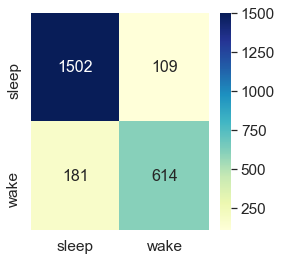


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.89245   0.93234   0.91196      1611
          2    0.84924   0.77233   0.80896       795

avg / total    0.87817   0.87947   0.87793      2406

TP, FN, FP, TN: 614, 181, 109, 1502
Sensitivity:0.9323401613904407
Specificity:0.7723270440251573
G-mean:0.8485702804556716


In [11]:
multiviewWithKMeans(X_train, y_train, X_test, y_test,'dt', 15)

Accuracy:
-----------------------------
0.9168744804655029

Confusion Matrix:
-----------------------------


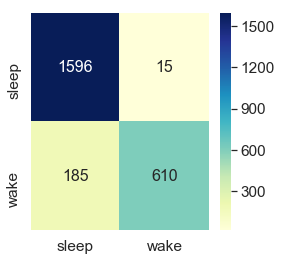


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.89613   0.99069   0.94104      1611
          2    0.97600   0.76730   0.85915       795

avg / total    0.92252   0.91687   0.91398      2406

TP, FN, FP, TN: 610, 185, 15, 1596
Sensitivity:0.9906890130353817
Specificity:0.7672955974842768
G-mean:0.8718665713158704


In [12]:
multiviewWithKMeans(X_train, y_train, X_test, y_test,'rf', 15)

Accuracy:
-----------------------------
0.9172901080631753

Confusion Matrix:
-----------------------------


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


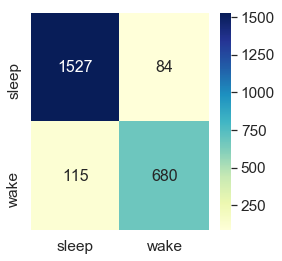


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.92996   0.94786   0.93883      1611
          2    0.89005   0.85535   0.87235       795

avg / total    0.91678   0.91729   0.91686      2406

TP, FN, FP, TN: 680, 115, 84, 1527
Sensitivity:0.9478584729981379
Specificity:0.8553459119496856
G-mean:0.9004148321667234


In [13]:
multiviewWithKMeans(X_train, y_train, X_test, y_test,'xgb', 15)

Accuracy:
-----------------------------
0.8669991687448046

Confusion Matrix:
-----------------------------


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


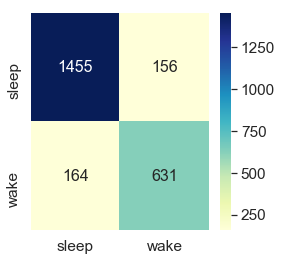


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.89870   0.90317   0.90093      1611
          2    0.80178   0.79371   0.79772       795

avg / total    0.86668   0.86700   0.86683      2406

TP, FN, FP, TN: 631, 164, 156, 1455
Sensitivity:0.9031657355679702
Specificity:0.7937106918238994
G-mean:0.8466713062394962


In [14]:
multiviewWithKMeans(X_train, y_train, X_test, y_test,'all', 15)

# Training and results - Agglomerative

Accuracy:
-----------------------------
0.9214463840399002

Confusion Matrix:
-----------------------------


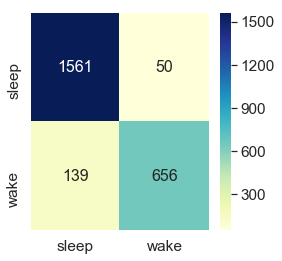


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.91824   0.96896   0.94292      1611
          2    0.92918   0.82516   0.87408       795

avg / total    0.92185   0.92145   0.92017      2406

TP, FN, FP, TN: 656, 139, 50, 1561
Sensitivity:0.9689633767846059
Specificity:0.8251572327044026
G-mean:0.8941739979330078


In [15]:
multiviewWithAgglomerative(X_train, y_train, X_test, y_test,'dt', 15)

Accuracy:
-----------------------------
0.9334995843724023

Confusion Matrix:
-----------------------------


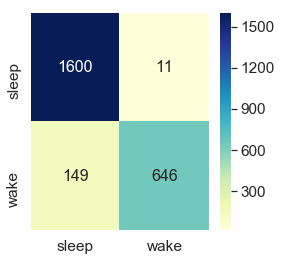


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.91481   0.99317   0.95238      1611
          2    0.98326   0.81258   0.88981       795

avg / total    0.93743   0.93350   0.93171      2406

TP, FN, FP, TN: 646, 149, 11, 1600
Sensitivity:0.9931719428926132
Specificity:0.8125786163522013
G-mean:0.8983486423185083


In [16]:
multiviewWithAgglomerative(X_train, y_train, X_test, y_test,'rf', 15)

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy:
-----------------------------
0.9243557772236076

Confusion Matrix:
-----------------------------


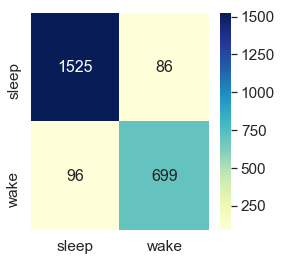


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.94078   0.94662   0.94369      1611
          2    0.89045   0.87925   0.88481       795

avg / total    0.92415   0.92436   0.92423      2406

TP, FN, FP, TN: 699, 96, 86, 1525
Sensitivity:0.946617008069522
Specificity:0.879245283018868
G-mean:0.912309453623364


In [17]:
multiviewWithAgglomerative(X_train, y_train, X_test, y_test,'xgb', 15)

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy:
-----------------------------
0.9326683291770573

Confusion Matrix:
-----------------------------


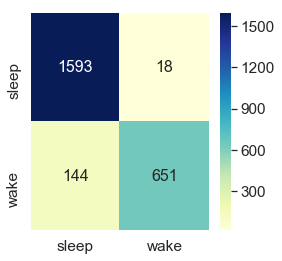


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.91710   0.98883   0.95161      1611
          2    0.97309   0.81887   0.88934       795

avg / total    0.93560   0.93267   0.93104      2406

TP, FN, FP, TN: 651, 144, 18, 1593
Sensitivity:0.9888268156424581
Specificity:0.8188679245283019
G-mean:0.8998436321067508


In [18]:
multiviewWithAgglomerative(X_train, y_train, X_test, y_test,'all', 15)